# Map of correlations

In [12]:
import xarray as xr
from pathlib import Path

import intake
import matplotlib.pyplot as plt
import easygems.healpix as egh
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import os

import netCDF4
import glob

In [13]:
# to get the land mask from ICON
# define paths
datapath = '/g/data/qx55/germany_node/d3hp003.zarr'
file = 'P1D'
zoom = 'z5'

# define the fname
fpath = f'{datapath}/{file}_mean_{zoom}_atm.zarr'

# open the zarr file
di = xr.open_zarr(fpath)
 

In [14]:

# total precipitaion - Directory path
data_dir = '/g/data/rt52/era5/single-levels/reanalysis/'
var = 'tp'
# Use glob to find files for June to August (months 06, 07, 08)
file_list = sorted(glob.glob(data_dir + var+ '/2020/'+var+'_era5_oper_sfc_20200[6-8]*.nc'))

# Load all files into one dataset
ds = xr.open_mfdataset(file_list, combine='by_coords')
ds['tp'] = ds['tp']
# Optional: slice time again if you want to ensure the exact range
ds_jja = ds.sel(time=slice('2020-06-01', '2020-08-31'))
era_pr = ds_jja['tp'].resample(time='1D').mean(dim='time') * 86400

In [15]:
# evaporation - Directory path
data_dir = '/g/data/rt52/era5/single-levels/reanalysis/'
var = 'e'
# Use glob to find files for June to August (months 06, 07, 08)
file_list = sorted(glob.glob(data_dir + var+ '/2020/'+var+'_era5_oper_sfc_20200[6-8]*.nc'))

# Load all files into one dataset
ds = xr.open_mfdataset(file_list, combine='by_coords')
    
# Convert from Kelvin to Celsius
#ds['t2m'] = ds['t2m'] - 273.15
ds[var] = ds[var]
# Optional: slice time again if you want to ensure the exact range
ds_jja = ds.sel(time=slice('2020-06-01', '2020-08-31'))
era_eva = ds_jja[var].resample(time='1D').mean(dim='time')


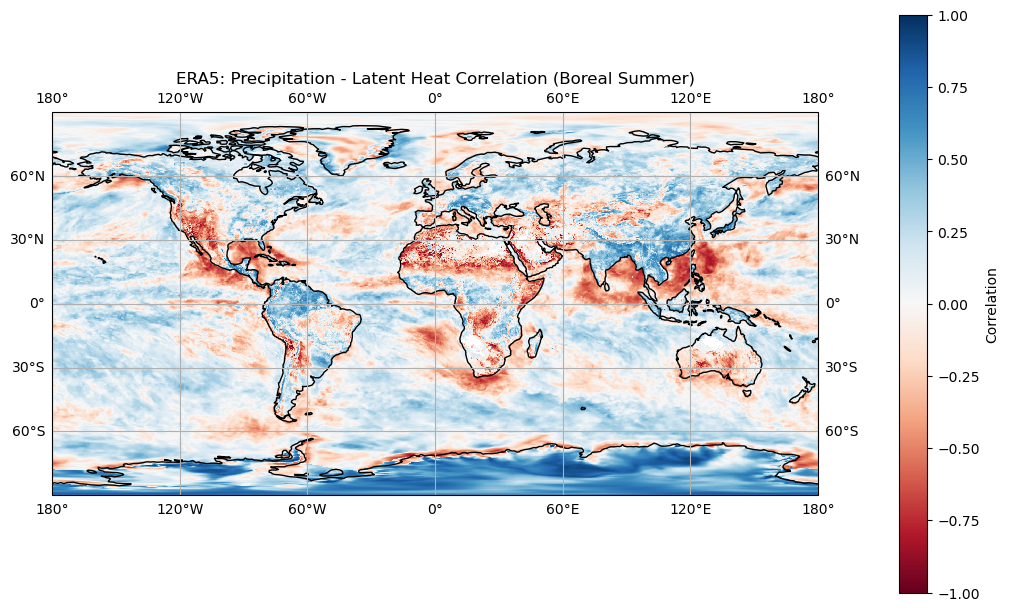

In [16]:
#boreal summer
#um_corr_lh_pr  = xr.where((di['sftlf']>0.9), xr.corr(era_pr, era_eva, dim='time'), np.nan)
um_corr_lh_pr  = xr.corr(era_pr, era_eva, dim='time')


plt.close('all')
projection = ccrs.PlateCarree(central_longitude=0.0)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection}, layout='constrained')

ax.set_global()
# Use pcolormesh for lat-lon gridded data
im = ax.pcolormesh(
    um_corr_lh_pr['longitude'], 
    um_corr_lh_pr['latitude'], 
    um_corr_lh_pr, 
    cmap='RdBu', 
    transform=ccrs.PlateCarree(),
    shading='auto',  # optional: prevents warnings
    vmin=-1, vmax=1   # correlation range
)

ax.set_title('ERA5: Precipitation - Latent Heat Correlation (Boreal Summer)', fontsize=12)
ax.coastlines()
ax.gridlines(draw_labels=True)

# Add colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Correlation')

plt.show()